# Index Generation

This Notebook include code for Preprocessing,indexing using Pyserini as well as creating the baselines as give TREC CAsT tutorial Notebook given in GRILL lab. This indexing is later stored in google bucket and accessed in colab for creating the updatated baseline

### Using Pyserini to build Sparse Index

In [29]:
##Installing and Setting up Dependancies
!pip install pyserini
!pip install faiss-cpu
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Preprocessing

### Preprocessing in a way Pyserini can use for indexing

In [77]:
#Pre-processing documents of KILT and WAPO
import os
from pathlib import Path
import json
from tqdm import tqdm

def format_collection(collection_path, output_path):
  """
  Runs through all documents and reformats them for indexing 
  with Pyserini.
  """
  Path(output_path).mkdir(parents=True, exist_ok=True)
  # iterate through all files in directory
  for file in tqdm(os.listdir(collection_path)):
    # open file
    with open(f"{collection_path}/{file}") as document_jsonl_collection:
              file_basename = os.path.basename(file)
              with open(f"{output_path}/{file_basename}_reformated.jsonl", "a") as reformated_collection_file:
                for document in document_jsonl_collection:
                              parsed_document = json.loads(document)
                              print(parsed_document)
                              parsed_document['passage_splits'] = parsed_document['body']
                              parsed_document['contents'] = " ".join(
                                  [passage['body'] for passage in parsed_document['contents']]
                              ).replace('\n', ' ')

                              # write to output file
                              reformated_collection_file.write(json.dumps(parsed_document) + "\n")

In [78]:
#Preprocessing documents of MARCO dataset
import os
from pathlib import Path
import json
from tqdm import tqdm

def format_collection(collection_path, output_path):
  """
  Runs through all documents and reformats them for indexing 
  with Pyserini.
  """
  Path(output_path).mkdir(parents=True, exist_ok=True)
  # iterate through all files in directory
  for file in tqdm(os.listdir(collection_path)):
    # open file
    with open(f"{collection_path}/{file}") as document_jsonl_collection:
              file_basename = os.path.basename(file)
              with open(f"{output_path}/{file_basename}_reformated.jsonl", "a") as reformated_collection_file:
                for document in document_jsonl_collection:
                            
                            parsed_document = json.loads(document)

                            
                            parsed_document['passage_splits'] = [{'body':parsed_document['contents'],'id':parsed_document['id'][7:]}]
                              
                              # write to output file
                            reformated_collection_file.write(json.dumps(parsed_document) + "\n")

In [79]:

format_collection("jsonfiles", "reformated_collection")

0it [00:00, ?it/s]


## Sparse Index Generation

In [30]:
#Generating Sparse Index using Pyserini
!python -m pyserini.index.lucene \
  --collection JsonCollection \
  --input files/reformated_collection \
  --index files/index/sparse \
  --generator DefaultLuceneDocumentGenerator \
  --threads 9 \
  --storePositions --storeDocvectors --storeRaw

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2022-09-09 01:48:07,636 INFO  [main] index.IndexCollection (IndexCollection.java:643) - Setting log level to INFO
2022-09-09 01:48:07,638 INFO  [main] index.IndexCollection (IndexCollection.java:646) - Starting indexer...
2022-09-09 01:48:07,638 INFO  [main] index.IndexCollection (IndexCollection.java:647) - ============ Loading Parameters ============
2022-09-09 01:48:07,638 INFO  [main] index.IndexCollection (IndexCollection.java:648) - DocumentCollection path: files/reformated_collection
2022-09-09 01:48:07,638 INFO  [main] index.IndexCollection (IndexCollection.java:649) - CollectionClass: JsonCollection
2022-09-09 01:48:07,639 INFO  [main] index.IndexCollection (

In [32]:
#Installing further dependencies
!pip install torchvision 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [33]:
#Loading the index and as an example printing out the top 10 documents for the word 'energy'
from pyserini.search.lucene import LuceneSearcher

sparse_searcher = LuceneSearcher('files/index/sparse')
search_term = 'Energy'
hits = sparse_searcher.search(search_term)

for i in range(len(hits)):
    print(f'{i+1:2} {hits[i].docid:4} {hits[i].score:.5f}')

 1 KILT_23721650 3.07670
 2 MARCO_D2376789 3.07530
 3 KILT_1841288 3.06990
 4 MARCO_D301665 3.06940
 5 MARCO_D3492750 3.06810
 6 MARCO_D368348 3.06800
 7 MARCO_D2144441 3.06740
 8 MARCO_D702738 3.06730
 9 MARCO_D604306 3.06710
10 MARCO_D163497 3.06710


In [34]:
#Printing out the best ranking document using the field 'content'
import json
best_ranked_doc = sparse_searcher.doc(hits[0].docid)
parsed_doc = json.loads(best_ranked_doc.raw())
parsed_doc['contents']

" Index of energy articles  This is an index of energy articles.   Section::::A.  Activation energy  - Alternative energy  - Alternative energy indexes  - American Museum of Science and Energy (AMSE)  - Anisotropy energy  - Atomic energy  Section::::B.  Binding energy  - Black hole  - Breeder reactor  - Brown energy  Section::::C.  Characteristic energy  - Conservation of energy  - Consol Energy  Section::::D.  Dark energy  - Decay energy  - Direct Energy  - Dirichlet's energy  - Dyson's sphere  Section::::E.  - Ecological energetics  - Electric Bond and Share Company  - Electric potential energy  - Electrochemical energy conversion  - Embodied energy  - Encircled energy  - Energy  - Energy accidents  - Energy accounting  - Energy amplifier  - Energy analyser  - Energy applications of nanotechnology  - Energy balance (biology)  - Energy bar  - Energy barrier  - Energy being  - Energy carrier  - Energy Catalyzer  - Energy cell  - Energy charge  - Energy conservation  - Energy conversion

# Query Rewriting

In [35]:
##Loading all the Manual Evaluation Topics provided by the TREC
import json

with open("files/2021_manual_evaluation_topics_v1.0.json") as cast_topics_file:
  topics = json.load(cast_topics_file)
  for topic in topics:
    print(f"Topic {topic['number']}")
    print("\n")
    for turn in topic['turn']:
      print(f"Turn {turn['number']}: {turn['raw_utterance']}")
      print(f"System Response: {turn['passage']}")
      print("\n")
    break

Topic 106


Turn 1: I just had a breast biopsy for cancer. What are the most common types?
System Response: More research is needed. Types Breast cancer can be: Ductal carcinoma: This begins in the milk duct and is the most common type. Lobular carcinoma: This starts in the lobules. Invasive breast cancer is when the cancer cells break out from inside the lobules or ducts and invade nearby tissue, increasing the chance of spreading to other parts of the body. Non-invasive breast cancer is when the cancer is still inside its place of origin and has not broken out.


Turn 2: Once it breaks out, how likely is it to spread?
System Response: Even though this condition doesn’t spread, it’s important to keep an eye on it. Between 20% to 40% of women with this condition will develop a separate invasive breast cancer -- one that will grow outside its original location -- within the next 15 years. Most of the time, these later cancers begin in the milk ducts, rather than the lobules. How is lobu

## Using T5 query Rewriter from Huggingface

In [36]:
# Load model and tokenizer available from the Huggingface 
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

device = "cuda" if torch.cuda.is_available() else "cpu" # setting up devie
rewriter = AutoModelForSeq2SeqLM.from_pretrained("castorini/t5-base-canard").to(device).eval()
rewriter_tokenizer = AutoTokenizer.from_pretrained("castorini/t5-base-canard")

In [37]:
# Getting turn attributes based on topic,id and type of utterance
def get_turn_attribute(topics: list, global_turn_id: str, attribute: str) -> str:
  """
  Returns topic and turn attributes
  """
  first_topic_number = 106
  topic_number, turn_number = global_turn_id.strip().split("_")

  # Get topic
  topic_index = int(topic_number) - first_topic_number
  topic = topics[topic_index]

  turn_index = int(turn_number) - 1
  extracted_attribute = topic['turn'][turn_index][attribute]

  return topic, turn_index, extracted_attribute

#Buidling context for the sentences
def build_context(topics: list, global_turn_id: str) -> str:
  """
  Given a global_turn_id, build rewriter model input (context)
  with all previous turn utterances and system responses
  """
  topic, turn_index, current_turn_utterance = get_turn_attribute(
      topics, global_turn_id, 'raw_utterance'
  )
  
  previous_turn_context = [f"{turn['raw_utterance']} ||| {turn['passage']}" for turn in topic['turn'][:turn_index]]
  previous_turn_context = (" ||| ").join(previous_turn_context)
  
  # return generated model input
  if previous_turn_context:
    return f"{previous_turn_context} ||| {current_turn_utterance}"
  else:
    return current_turn_utterance

In [38]:
#Building the Context for turn 3 in topic 113
global_turn_id = "113_3"

# get raw utterance
_, _, raw_utterance = get_turn_attribute(topics, global_turn_id, 'raw_utterance')
print(f"Raw Utterance: {raw_utterance}")

# build context
model_input = build_context(topics, global_turn_id)
print(f"Turn Context: {model_input}")

Raw Utterance: What are the other types of diseases?
Turn Context: How do genes work? ||| Genes A gene is a short piece of DNA. Genes tell the body how to build specific proteins. There are about 20,000 genes in each cell of the human body. Together, they make up the blueprint for the human body and how it works. A person's genetic makeup is called a genotype. Information Genes are made of DNA. Strands of DNA make up part of your chromosomes. Chromosomes have matching pairs of 1 copy of a specific gene. The gene occurs in the same position on each chromosome. Genetic traits, such as eye color, are dominant or recessive: Dominant traits are controlled by 1 gene in the pair of chromosomes. Recessive traits need both genes in the gene pair to work together. Many personal characteristics, such as height, are determined by more than 1 gene. However, some diseases, such as sickle cell anemia, can be caused by a change in a single gene. ||| What other diseases are caused by a single change? |

In [39]:
#Creating a function rewrite_query which rewrites the query based on the built context
def rewrite_query(context: str, model, tokenizer, device) -> str:
  tokenized_context = tokenizer.encode(context, return_tensors="pt").to(device)
  output_ids = model.generate(
      tokenized_context, max_length=200, num_beams=4, 
      repetition_penalty=2.5, length_penalty=1.0, 
      early_stopping=True).to(device)
      
  rewrite = tokenizer.decode(output_ids[0], skip_special_tokens=True)
  return rewrite

In [40]:
rewrite = rewrite_query(model_input, rewriter, rewriter_tokenizer, device)
print(f"Query Rewrite: {rewrite}")

Query Rewrite: Besides sickle cell anemia and cystic fibrosis, what are the other types of diseases?


### Checking for query rewrite failure as given the TREC CAsT tutoral

In [41]:
global_turn_id = "114_3"

# get turn attributes
_, _, failure_raw_utterance = get_turn_attribute(topics, global_turn_id, 'raw_utterance')
_, _, failure_manual_utterance = get_turn_attribute(topics, global_turn_id, 'manual_rewritten_utterance')
print(f"Raw Utterance: {failure_raw_utterance}")
print(f"Manual Utterance: {failure_manual_utterance}")

Raw Utterance: No, I meant to help my ferritin specifically.
Manual Utterance: No, I meant what should I consider changing in my diet to help my ferritin levels specifically.


In [42]:
failure_model_input = build_context(topics, global_turn_id)
failure_rewrite = rewrite_query(failure_model_input, rewriter, rewriter_tokenizer, device)
print(f"Query Rewrite: {failure_rewrite}")

Query Rewrite: No, I meant to help my ferritin specifically.


### Rewriter Evaluation

In [43]:
# Install ROUGE-score library
!pip install rouge-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [44]:
#Using Rouge socre for checking the quality of a single query rewrite
from rouge_score import rouge_scorer

# get manual rewrite for query
_, _, manual_rewritten_utterance = get_turn_attribute(topics, global_turn_id, 'manual_rewritten_utterance')
print(f"Manual Rewritten Utterance: {manual_rewritten_utterance}")

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score(rewrite, manual_rewritten_utterance)
print("\n")
print("ROUGE Scores")
print(scores)

Manual Rewritten Utterance: No, I meant what should I consider changing in my diet to help my ferritin levels specifically.


ROUGE Scores
{'rouge1': Score(precision=0.058823529411764705, recall=0.07142857142857142, fmeasure=0.06451612903225808), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.058823529411764705, recall=0.07142857142857142, fmeasure=0.06451612903225808)}


In [45]:
#Using rogue score to calculate quality of all rewrites
from rouge_score import rouge_scorer
import pandas as pd
turn_id_arr=[]
rogue1_precision=[]
rogue1_recall=[]
rogue1_fmeasure =[]

rogue2_precision = []
rogue2_recall = []
rogue2_fmeasure = []

roguel_precision = []
roguel_recall = []
roguel_fmeasure = []
for topic in topics:
  for turn in topic['turn']:
    # get turn id

    turn_id = f"{topic['number']}_{turn['number']}"
    print(turn_id)
    turn_id_arr.append(turn_id)
    # Build rewriter input -- not ideal, but saves having to write logic again
    query_and_context = build_context(topics, turn_id)
    print(query_and_context)
    # rewrite query
    _, _, raw_utterance = get_turn_attribute(topics, turn_id, 'raw_utterance')
    print(f"Raw utterance: {raw_utterance}")
    _, _, manual_rewritten_utterance = get_turn_attribute(topics, turn_id, 'manual_rewritten_utterance')
    print(f"Manual Rewritten Utterance: {manual_rewritten_utterance}")
    rewrite = rewrite_query(query_and_context, rewriter, rewriter_tokenizer, device)
    print("Rewrite" + rewrite)
    #break
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(rewrite, manual_rewritten_utterance)
    #print(scores)
    rogue1_precision.append(scores['rouge1'].precision)
    rogue1_recall.append(scores['rouge1'].recall)
    rogue1_fmeasure.append(scores['rouge1'].fmeasure)

    rogue2_precision.append(scores['rouge2'].precision)
    rogue2_recall.append(scores['rouge2'].recall)
    rogue2_fmeasure.append(scores['rouge2'].fmeasure)


    roguel_precision.append(scores['rougeL'].precision)
    roguel_recall.append(scores['rougeL'].recall)
    roguel_fmeasure.append(scores['rougeL'].fmeasure)


    rogue1_scores = pd.DataFrame({'turn_id':turn_id_arr,'Precison':rogue1_precision,'Recall':rogue1_recall,'Fmeasure':rogue1_fmeasure})
    rogue2_scores = pd.DataFrame({'turn_id':turn_id_arr,'Precison':rogue2_precision,'Recall':rogue2_recall,'Fmeasure':rogue2_fmeasure})
    roguel_scores = pd.DataFrame({'turn_id':turn_id_arr,'Precison':roguel_precision,'Recall':roguel_recall,'Fmeasure':roguel_fmeasure})



    

106_1
I just had a breast biopsy for cancer. What are the most common types?
Raw utterance: I just had a breast biopsy for cancer. What are the most common types?
Manual Rewritten Utterance: I just had a breast biopsy for cancer. What are the most common types of breast cancer?
RewriteWhat are the most common types of cancer in regards to me?
106_2
I just had a breast biopsy for cancer. What are the most common types? ||| More research is needed. Types Breast cancer can be: Ductal carcinoma: This begins in the milk duct and is the most common type. Lobular carcinoma: This starts in the lobules. Invasive breast cancer is when the cancer cells break out from inside the lobules or ducts and invade nearby tissue, increasing the chance of spreading to other parts of the body. Non-invasive breast cancer is when the cancer is still inside its place of origin and has not broken out. ||| Once it breaks out, how likely is it to spread?
Raw utterance: Once it breaks out, how likely is it to sprea

Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors


RewriteWhat are common treatments for LCIS and ALH?
106_6
I just had a breast biopsy for cancer. What are the most common types? ||| More research is needed. Types Breast cancer can be: Ductal carcinoma: This begins in the milk duct and is the most common type. Lobular carcinoma: This starts in the lobules. Invasive breast cancer is when the cancer cells break out from inside the lobules or ducts and invade nearby tissue, increasing the chance of spreading to other parts of the body. Non-invasive breast cancer is when the cancer is still inside its place of origin and has not broken out. ||| Once it breaks out, how likely is it to spread? ||| Even though this condition doesn’t spread, it’s important to keep an eye on it. Between 20% to 40% of women with this condition will develop a separate invasive breast cancer -- one that will grow outside its original location -- within the next 15 years. Most of the time, these later cancers begin in the milk ducts, rather than the lobules. How i

In [46]:
rogue1_scores

,turn_id,Precison,Recall,Fmeasure
0,106_1,0.470588,0.666667,0.551724
1,106_2,0.769231,0.909091,0.833333
2,106_3,0.428571,0.750000,0.545455
3,106_4,0.571429,0.888889,0.695652
4,106_5,0.312500,0.625000,0.416667
...,...,...,...,...
234,131_6,0.933333,1.000000,0.965517
235,131_7,0.636364,1.000000,0.777778
236,131_8,0.785714,1.000000,0.880000
237,131_9,1.000000,1.000000,1.000000


In [47]:
#Printing out total number of values less than 50%
rogue1_scores[rogue1_scores['Precison'] < 0.5].shape

(63, 4)

In [48]:
#Storing it in an array
Incorrect_writes_1 = rogue1_scores[rogue1_scores['Precison'] < 0.5].sort_values(by='Precison', ascending=True)

In [49]:
Incorrect_writes_1.head()

,turn_id,Precison,Recall,Fmeasure
172,124_5,0.000000,0.000000,0.000000
15,107_6,0.111111,0.142857,0.125000
40,110_8,0.111111,0.142857,0.125000
75,113_11,0.130435,0.230769,0.166667
71,113_7,0.176471,0.300000,0.222222


In [51]:
rogue2_scores[rogue2_scores['Precison'] < 0.5].shape

(112, 4)

In [52]:
Incorrect_writes_2 = rogue2_scores[rogue2_scores['Precison'] < 0.5].sort_values(by='Precison', ascending=True)

In [53]:
Incorrect_writes_2.head()

,turn_id,Precison,Recall,Fmeasure
39,110_7,0.0,0.0,0.0
190,126_6,0.0,0.0,0.0
172,124_5,0.0,0.0,0.0
75,113_11,0.0,0.0,0.0
71,113_7,0.0,0.0,0.0


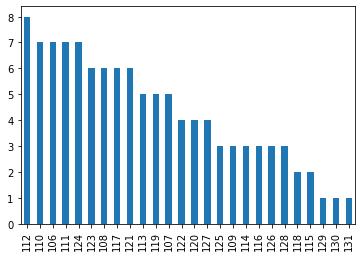

In [18]:
Incorrect_writes_2['turn_id'].str.split('_',n=-1, expand=True)[0].value_counts().plot(kind='bar');

In [54]:
roguel_scores[roguel_scores['Precison'] < 0.5].shape

(79, 4)

In [55]:
Incorrect_writes_L = roguel_scores[roguel_scores['Precison'] < 0.5].sort_values(by='Precison', ascending=True)

In [56]:
Incorrect_writes_L.head()

,turn_id,Precison,Recall,Fmeasure
172,124_5,0.000000,0.000000,0.000000
40,110_8,0.111111,0.142857,0.125000
15,107_6,0.111111,0.142857,0.125000
71,113_7,0.117647,0.200000,0.148148
75,113_11,0.130435,0.230769,0.166667


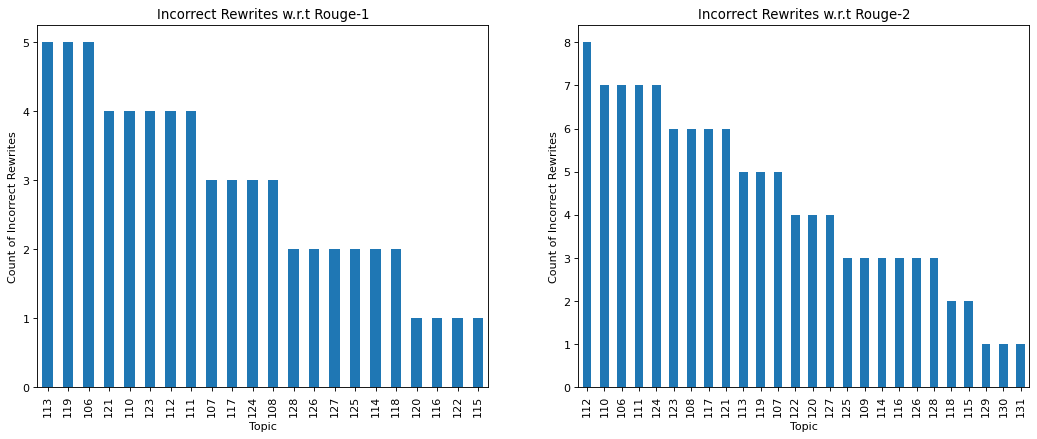

In [58]:
#Analyging Rouge 1, Rouge2 and Rouge-l scores
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6), dpi=80)
rows, cols = 1, 2
plt.subplot(rows, cols, 1)
plt.xlabel('Topic')
plt.ylabel('Count of Incorrect Rewrites')
plt.title("Incorrect Rewrites w.r.t Rouge-1")
Incorrect_writes_1['turn_id'].str.split('_',n=-1, expand=True)[0].value_counts().plot(kind='bar');
plt.subplot(rows, cols, 2)
plt.xlabel('Topic')
plt.ylabel('Count of Incorrect Rewrites')
plt.title("Incorrect Rewrites w.r.t Rouge-2")
Incorrect_writes_2['turn_id'].str.split('_',n=-1, expand=True)[0].value_counts().plot(kind='bar');
plt.show()

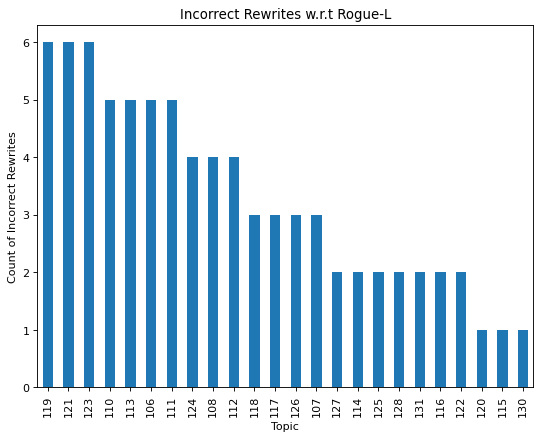

In [59]:
plt.figure(figsize=(8, 6), dpi=80)
plt.xlabel('Topic')
plt.ylabel('Count of Incorrect Rewrites')
plt.title("Incorrect Rewrites w.r.t Rogue-L")
Incorrect_writes_L['turn_id'].str.split('_',n=-1, expand=True)[0].value_counts().plot(kind='bar');
plt.show()

## Passage Ranking- Extracting the Passage that are most relavent for the query

In [61]:
#Collecting all the packages using sparse searcher class and doc_id
def collect_passages(hits: list) -> dict:
  """
  Extracts and collects all passages from candidate documents
  """
  all_passages = []
  for hit in hits:
    doc_id = hit.docid
    document = sparse_searcher.doc(doc_id)
    passages = json.loads(document.raw())['passage_splits']
    for passage in passages:
        passage['id'] = f"{doc_id}-{passage['id']}" 
    all_passages.extend(passages)

  return all_passages

In [62]:

passages = collect_passages(hits)

# Examine one of the passages
print(len(passages))
passages


27


[{'body': ' Index of energy articles  This is an index of energy articles. ',
  'id': 'KILT_23721650-1'},
 {'body': " Section::::A.  Activation energy  - Alternative energy  - Alternative energy indexes  - American Museum of Science and Energy (AMSE)  - Anisotropy energy  - Atomic energy  Section::::B.  Binding energy  - Black hole  - Breeder reactor  - Brown energy  Section::::C.  Characteristic energy  - Conservation of energy  - Consol Energy  Section::::D.  Dark energy  - Decay energy  - Direct Energy  - Dirichlet's energy  - Dyson's sphere  Section::::E.  - Ecological energetics  - Electric Bond and Share Company  - Electric potential energy  - Electrochemical energy conversion  - Embodied energy  - Encircled energy  - Energy  - Energy accidents  - Energy accounting  - Energy amplifier  - Energy analyser  - Energy applications of nanotechnology  - Energy balance (biology)  - Energy bar  - Energy barrier  - Energy being  - Energy carrier  - Energy Catalyzer  - Energy cell  - Energy

### Now for ranking these passages according to their relavence, using T5-based Model.Cross Encoder is used for finding out similarity between query rewrite and candidate passage which is quantified between 0 and 1

In [63]:
# install dependencies
!pip install sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [64]:
#Cross Encoder
from sentence_transformers import CrossEncoder

# loading cross encoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [65]:
#Reranking passages
def rank_passages_cross_encoder(rewrite: str, passages: list, cross_encoder: CrossEncoder) -> list:
  """
  Uses a cross encoder to compute the similarity between a query rewrite and a list of
  passages
  """
  query_passage_pairs = [[rewrite, passage['body']] for passage in passages]
  cross_scores = cross_encoder.predict(query_passage_pairs)

  for passage, score in zip(passages, cross_scores):
    passage['score'] = score
  
  ranked_passages = sorted(passages, key=lambda x: x['score'], reverse=True)
  return ranked_passages


In [66]:
ranked_passages = rank_passages_cross_encoder( rewrite, passages, cross_encoder)

In [67]:
print(f"Raw Utterance: {raw_utterance}")
print(f"Rewrite: {rewrite}")
print(f"Manual Rewrite: {manual_rewritten_utterance}")

Raw Utterance: How is it different from a heat pump?
Rewrite: How is an AC compressor different from a heat pump?
Manual Rewrite: How is an AC system different from a heat pump?


In [68]:
#Printing out top 10 relavent passages
print("Top 10 relevant passages:")
print("\n")
for passage in ranked_passages[:10]:
  print(passage)

Top 10 relevant passages:


{'body': '"From Wikipedia, the free encyclopedianavigation search This article needs additional citations for verification. Please help improve this article by adding citations to reliable sources. Unsourced material may be challenged and removed. (July 2017) ( Learn how and when to remove this template message)Energy Transformation in Energy Systems Language. Energy transformation, also termed as energy conversion, is the process of changing energy from one of its forms into another. In physics, energy is a quantity that provides the capacity to perform many actions—think of lifting or warming an object. In addition to being convertible, energy is transferable to a different location or object, but it cannot be created or destroyed. Energy in many of its forms may be used in natural processes, or to provide some service to society such as heating, refrigeration, lightening or performing mechanical work to operate machines. For example, in order to heat your

In [69]:
#T5 model
ranker_tokenizer = AutoTokenizer.from_pretrained('castorini/monot5-base-msmarco-10k')
ranker = AutoModelForSeq2SeqLM.from_pretrained('castorini/monot5-base-msmarco-10k', return_dict=True).to(device).eval()

In [70]:
#ranked passages
prediction_tokens = ['▁false', '▁true']
token_false_id = ranker_tokenizer.get_vocab()[prediction_tokens[0]]
token_true_id  = ranker_tokenizer.get_vocab()[prediction_tokens[1]]

def rank_passages_t5(
    rewrite: str, passages: list, model: AutoModelForSeq2SeqLM, tokenizer: AutoTokenizer):
    
    input_ids = tokenizer(
        [f"Query: {rewrite} Document: {passage['body']} Relevant: " for passage in passages], 
        return_tensors="pt", padding=True, truncation=True
    ).to(device).input_ids

    outputs = model.generate(
        input_ids,
        return_dict_in_generate=True, 
        output_scores=True 
    )
    
    scores = outputs.scores[0][:, [token_false_id, token_true_id]]
    scores = torch.nn.functional.softmax(scores, dim=1)
    probabilities = scores[:, 1].tolist()

    for passage, probability in zip(passages, probabilities):
        passage['score'] = probability

    ranked_passages = sorted(passages, key=lambda x: x['score'], reverse=True)
    return ranked_passages

In [71]:
ranked_passages_t5 = rank_passages_t5(rewrite, passages[:52], ranker, ranker_tokenizer)

In [72]:
#Printing Top 10 relavent documents
print("Top relevant passages from T5:")
print("\n")
for passage in ranked_passages_t5[:10]:
  print(passage)

Top relevant passages from T5:


{'body': ' BULLET::::- Volt  BULLET::::- Ampere  BULLET::::- Coulomb  BULLET::::- Enthalpy  BULLET::::- EU energy label  BULLET::::- Fill factor – defined as the ratio of the maximum power (Vmp x Jmp) divided by the short-circuit current (Isc) and open-circuit voltage (Voc) in light current density – voltage (J-V) characteristics of solar cells.  BULLET::::- Gigaton – Metric Unit of mass, equal to 1,000,000,000 (1 billion) metric tons, 1,000,000,000,000 (1 trillion) kilograms  BULLET::::- Any of various units of energy, such as gigatons of TNT equivalent, gigatons of coal equivalent, gigatons petroleum equivalent.   BULLET::::- Gray (unit) – (symbol: Gy), is the SI unit of energy for the absorbed dose of radiation.  One gray is the absorption of one joule of radiation energy by one kilogram of matter.  One gray equals 100 rad, an older unit.   BULLET::::- Heat  BULLET::::- Mass-energy equivalence – where mass has an energy equivalence, and energy has a 

In [73]:
## Encapsulating all the components into a class BASECAsTSystem as defined in TREC CAsT Tools
from abc import ABC, abstractmethod

class BaseCAsTSystem(ABC):

  @abstractmethod
  def rewrite_query(self, query: str, context: str) -> str:
    pass
  
  @abstractmethod
  def retrieve_docments(self, query: str) -> list:
    pass

  @abstractmethod
  def rank_passages(self, query: str, passages: list) -> list:
    pass

In [74]:
class FirstCAsTSystem(BaseCAsTSystem):

  def __init__(self, query_rewriter, query_rewriter_tokenizer, 
               search_system, passage_ranker, device) -> None:
    self.query_rewriter = query_rewriter
    self.query_rewriter_tokenizer = query_rewriter_tokenizer
    self.search_system = search_system
    self.passage_ranker = passage_ranker
    self.device = device
  
  def rewrite_query(self, query_and_context: str) -> str:
    """
    Simple CAsT System Query Rewriter
    """

    tokenized_context = self.query_rewriter_tokenizer.encode(
        query_and_context, return_tensors="pt"
    ).to(self.device)

    output_ids = self.query_rewriter.generate(
        tokenized_context, max_length=200, num_beams=4, 
        repetition_penalty=2.5, length_penalty=1.0, 
        early_stopping=True).to(device)

    rewrite = self.query_rewriter_tokenizer.decode(
        output_ids[0], skip_special_tokens=True
    )
    return rewrite 
  
  def retrieve_docments(self, query: str) -> list:
    """
    Simple CAsT System Document Retriever
    """
    hits = self.search_system.search(query)
    return hits
  
  def rank_passages(self, query: str, passages: list) -> list:
    """
    Simple CAsT System Passage Ranker
    """
    query_passage_pairs = [[query, passage['body']] for passage in passages]
    query_passage_scores = self.passage_ranker.predict(query_passage_pairs)

    for passage, score in zip(passages, query_passage_scores):
      passage['score'] = score
    
    ranked_passages = sorted(passages, key=lambda x: x['score'], reverse=True)
    return ranked_passages

### Finding out top 3 Passages

In [75]:

# create system instance
simple_cast_system = FirstCAsTSystem(
    query_rewriter=rewriter,
    query_rewriter_tokenizer=rewriter_tokenizer,
    search_system=sparse_searcher,
    passage_ranker=cross_encoder,
    device=device
)

In [81]:
#Display format of the results
for topic in topics[:1]:
  for turn in topic['turn']:
    # get turn id
    turn_id = f"{topic['number']}_{turn['number']}"
    # Build rewriter input -- not ideal, but saves having to write logic again
    query_and_context = build_context(topics, turn_id)
    # rewrite query
    rewrite = simple_cast_system.rewrite_query(query_and_context)
    # retrieve candidate documents
    candidate_documents = simple_cast_system.retrieve_docments(rewrite)
    # collect passages from candidate documents
    extracted_passages = collect_passages(candidate_documents)
    # rank passages
    ranked_passages = simple_cast_system.rank_passages(rewrite, extracted_passages)
    # print output
    print(f"Turn ID: {turn_id}")
    print(f"Query: {turn['raw_utterance']}")
    print(f"Rewrite: {rewrite}")
    print(f"Manual Rewrite: {turn['manual_rewritten_utterance']}")
    print("\n")
    print("Top Passages:")
    for passage in ranked_passages[:3]:
      print(f"Passage ID: {passage['id']}")
      print(f"Score {passage['score']}")
      print(f"Text: {passage['body']}")
      print("\n")
    print("------------------")



Turn ID: 106_1
Query: I just had a breast biopsy for cancer. What are the most common types?
Rewrite: What are the most common types of cancer in regards to me?
Manual Rewrite: I just had a breast biopsy for cancer. What are the most common types of breast cancer?


Top Passages:
Passage ID: MARCO_D2994709-2994709
Score 0.7519786357879639
Text: "Health Diseases & Conditions Cancer Is bone cancer curable? Please tell me some AYURVEDIC treatments please. Update: I hv 4th stage cancer. Now it has gone to my bones,in spinal bones,in hip bones . I hv very severe pain I can't sleep at nights.2 following 10 answers Answers Relevance Rating Newest Oldest Best Answer: Bone cancer is a malignant (cancerous) tumor of the bone that destroys normal bone tissue Not all bone tumors are malignant. In fact, benign (noncancerous) bone tumors are more common than malignant ones. Both malignant and benign bone tumors may grow and compress healthy bone tissue, but benign tumors do not spread, do not destro

In [84]:
#Genrating a runfile with all the results
from tqdm import tqdm

with open("files/simple_cast_system_baseline.run", "a") as run_file:
  for topic in tqdm(topics):
    for turn in topic['turn']:
      # get turn id
      turn_id = f"{topic['number']}_{turn['number']}"
      # Build rewriter input -- not ideal, but saves having to write logic again
      query_and_context = build_context(topics, turn_id)
      # rewrite query
      rewrite = simple_cast_system.rewrite_query(query_and_context)
      # retrieve candidate documents
      candidate_documents = simple_cast_system.retrieve_docments(rewrite)
      # collect passages from candidate documents
      extracted_passages = collect_passages(candidate_documents)
      # rank passages
      ranked_passages = simple_cast_system.rank_passages(rewrite, extracted_passages)
      # Write output to run file
      for rank, passage in enumerate(ranked_passages):
        run_file.write(f"{turn_id}\tQ0\t{passage['id']}\t{rank+1}\t{passage['score']}\tsimple-cast-system\n")
      # print(f"Wrote passage rankings for Turn {turn_id} to file")

100%|██████████| 26/26 [52:25<00:00, 121.00s/it]


In [ ]:
!git clone https://github.com/usnistgov/trec_eval.git
%cd trec_eval
!make
!mv trec_eval /
usr/local/bin
%cd ..

In [ ]:
# Year 3 relevance judgements contain document ranking, so need to deduplicate run as given in the TREC CAsT System
def deduplicate_run(run_file: str) -> list:

    # {'106_1': [], '106_2' : [], ... }
    document_ids = {}

    with open(run_file) as f:
        run_rows: list = []

        for line in f:
            line_dict: dict = {}
            line_content = line.split()
            line_content[2] = line_content[2].rsplit("-",1)[0]

            # check if turn_id is in the dictionary
            if document_ids.get(line_content[0]):
                # check if turn has document id in its list
                if line_content[2] not in document_ids[line_content[0]]:
                    document_ids[line_content[0]].append(line_content[2])

                    line_dict = {
                        "turn_id": line_content[0],
                        "dummy_value": line_content[1],
                        "doc_id": line_content[2],
                        "rank": line_content[3],
                        "score": line_content[4],
                        "run_name": line_content[5]
                    }
                    run_rows.append(line_dict)
            else:
                document_ids[line_content[0]] = []
                document_ids[line_content[0]].append(line_content[2])

                line_dict = {
                    "turn_id": line_content[0],
                    "dummy_value": line_content[1],
                    "doc_id": line_content[2],
                    "rank": line_content[3],
                    "score": line_content[4],
                    "run_name": line_content[5]
                }
                run_rows.append(line_dict)

        return run_rows


def adjust_run_ranking(run_rows: list) -> list:

    for i in range(1, len(run_rows)):
        if run_rows[i]["turn_id"] == run_rows[i-1]["turn_id"]:
            run_rows[i]["rank"] = str(int(run_rows[i-1]["rank"]) + 1)
        else:
            run_rows[i]['rank'] = str(1)

    return run_rows

In [ ]:

deduplicated_run = deduplicate_run("files/simple_cast_system.run")
adjusted_run = adjust_run_ranking(deduplicated_run)

with open(f"files/simple_cast_system_deduped.run", "w") as deduped_run_file:
    for row in adjusted_run:
        deduped_run_file.write(
            f'{row["turn_id"]} {row["dummy_value"]} {row["doc_id"]} {row["rank"]} {row["score"]} {row["run_name"]}\n')

In [ ]:
#downloading trec_eval tool for evaluation
!conda install -c conda-forge trec_eval

In [1]:
#checking NDCG@3 scores.
sh = """
trec_eval -q -m ndcg files/trec-cast-qrels-docs.2021.qrel files/simple_cast_system_deduped.run
"""
with open('script.sh', 'w') as file:
  file.write(sh)
!bash script.sh


ndcg                  	106_1	0.0000
ndcg                  	106_10	0.0670
ndcg                  	106_2	0.0078
ndcg                  	106_3	0.0402
ndcg                  	106_4	0.4064
ndcg                  	106_5	0.0697
ndcg                  	106_6	0.4515
ndcg                  	106_7	0.5759
ndcg                  	106_8	0.0000
ndcg                  	107_1	0.0821
ndcg                  	107_2	0.1843
ndcg                  	107_3	0.2135
ndcg                  	107_4	0.0000
ndcg                  	107_5	0.3150
ndcg                  	107_6	0.1159
ndcg                  	107_7	0.3069
ndcg                  	107_8	0.1747
ndcg                  	108_1	0.1962
ndcg                  	108_2	0.2073
ndcg                  	108_3	0.0000
ndcg                  	108_4	0.0851
ndcg                  	108_5	0.1581
ndcg                  	108_6	0.2304
ndcg                  	108_7	0.0979
ndcg                  	108_8	0.0661
ndcg                  	110_1	0.3269
ndcg                  	110_2	0.1947
ndcg                  	110_

In [ ]:
# Uploading the above to a CSV file

In [85]:
#reading the updated CSV file
import pandas as pd
df_baseline = pd.read_csv('ndcg baseline scores.csv', names=["Topic ID", "Score"])
df_baseline

,Topic ID,Score
0,106_1,0.0000
1,106_10,0.0670
2,106_2,0.0078
3,106_3,0.0402
4,106_4,0.4064
...,...,...
154,131_6,0.0947
155,131_7,0.1997
156,131_8,0.1709
157,131_9,0.0415


In [86]:
#Splitting the topic file
df_baseline["Topic"]= df_baseline['Topic ID'].str.split('_',n=-1, expand=True)[0]

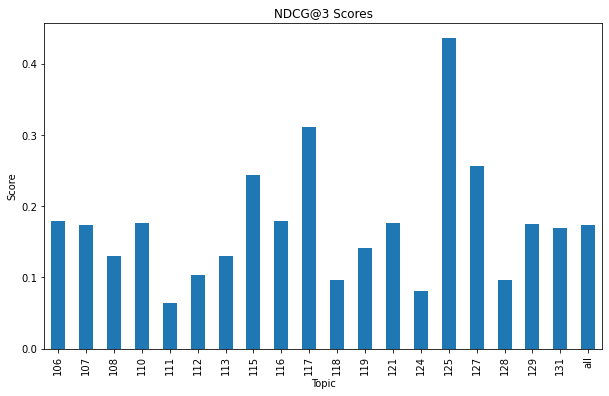

In [87]:
#barplot of average ndcg score per topic file
import matplotlib.pyplot as plt
df_groups = df_baseline.groupby(['Topic'])['Score'].mean()
df_groups.plot(kind='bar', title='NDCG@3 Scores',
               ylabel='Score', xlabel='Topic', figsize=(10, 6))
plt.show()